# Elementy Inteligencji Obliczeniowej - Sieci Neuronowe


---

**Prowadzący:** Jakub Bednarek<br>
**Kontakt:** jakub.bednarek@put.poznan.pl<br>
**Materiały:** [Strona WWW](http://jakub.bednarek.pracownik.put.poznan.pl)

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji

## Cel ćwiczeń:
- zapoznanie się z Keras subclassing API
- stworzenie własnych modeli i warstw z wykorzystaniem Keras subclassing API
- wykorzystanie podstawowych mechanizmów regularyzacji: Dropout i Batch normalization

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, RMSprop
from tensorflow.python.keras import backend as K


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train[:, :, :, np.newaxis].astype('float32')
x_test = x_test[:, :, :, np.newaxis].astype('float32')
x_train /= 255
x_test /= 255

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

11493376/11490434 [==============================] - 0s 0us/step


## Tworzenie własnych modeli i warstw 
https://www.tensorflow.org/guide/keras/custom_layers_and_models

Przykładowy model z warstwami gęstymi dla danych MNIST:

In [0]:
class DenseModel(Model):

  def __init__(self, num_classes=10):
    super(DenseModel, self).__init__(name='my_model')
    self.num_classes = num_classes
    # Define your layers here.
    self.dense_1 = Dense(512, input_shape=(784,), activation='relu')
    self.dense_2 = Dense(512, activation='relu')
    self.dense_3 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    # Define your forward pass here,
    # using layers you previously defined (in `__init__`).
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    return self.dense_3(x)

model = DenseModel(num_classes=10)

In [5]:
model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=32, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 18s 292us/sample - loss: 0.1935 - accuracy: 0.9427
Epoch 2/3
60000/60000 [==============================] - 17s 280us/sample - loss: 0.1004 - accuracy: 0.9740
Epoch 3/3
60000/60000 [==============================] - 17s 276us/sample - loss: 0.0834 - accuracy: 0.9800


Przykład własnej warstwy.

In [6]:
class CustomLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CustomLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(int(input_shape[1]), self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)


class CustomModel(Model):

    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__(name='custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.dense_1 = CustomLayer(output_dim=512, input_shape=(784,))
        self.dense_2 = CustomLayer(output_dim=512, input_shape=(512,))
        self.dense_3 = CustomLayer(output_dim=num_classes, input_shape=(512,))

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense_1(inputs)
        x = K.relu(x)
        x = self.dense_2(x)
        x = K.relu(x)
        x = self.dense_3(x)
        x = K.sigmoid(x)
        return x

model = CustomModel(num_classes=10)

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(x_train, y_train, batch_size=128, epochs=3)




Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 7s 123us/sample - loss: 0.2822 - accuracy: 0.9139
Epoch 2/3
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0963 - accuracy: 0.9711
Epoch 3/3
60000/60000 [==============================] - 7s 117us/sample - loss: 0.0631 - accuracy: 0.9809


### Zadanie 1
Na podstawie powyższego przykładu stwórz własny model kolejno składający się z:
- warstwy konwolucyjnej (Conv2D): 32 filtry 3x3,
- konwolucyjnej: 64 filtry 3x3,
- warstwy MaxPooling (MaxPooling2D): 2x2
- warstwy ukrytej gęstej (Dense): 128 neuronów,
- warstwy wyjściowej.

Ważne:
- w każdej warstwie poza warstwą wyjściową funkcją aktywacji powinno być relu,
- funkcja aktywacji dla warstwy wyjściowej to softmax,
- między częścią konwolucyjną a gęstą trzeba spłaszczyć tensor przy pomocy warstwy (Flatten),
- w przykładzie jest wykorzystywana sieć gęsta (dane są spłaszczone), sieci z warstwami konwolucyjnymi muszą otrzymać tensor 4-wymiarowy, zakomentuj linie "spłaszczające" podczas wczytywania danych.
```
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
```

In [28]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train[:, :, :, np.newaxis].astype('float32')
x_test = x_test[:, :, :, np.newaxis].astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

class FirstModel(Model):

  def __init__(self, num_classes=10):
    super(FirstModel, self).__init__(name='first_model')
    self.num_classes = num_classes

    self.conv_1 = Conv2D(32, (3,3), activation='relu')
    self.conv_2 = Conv2D(64, (3,3), activation='relu')
    self.maxpooling = MaxPooling2D(pool_size=(2,2))
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(self.num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.maxpooling(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    return self.dense_2(x)

model = FirstModel(num_classes=10)

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


firstModel = model.fit(x_train, y_train, batch_size=32, epochs=3, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 158s 3ms/sample - loss: 0.1071 - accuracy: 0.9670 - val_loss: 0.0492 - val_accuracy: 0.9839
Epoch 2/3
60000/60000 [==============================] - 158s 3ms/sample - loss: 0.0405 - accuracy: 0.9877 - val_loss: 0.0386 - val_accuracy: 0.9881
Epoch 3/3
60000/60000 [==============================] - 158s 3ms/sample - loss: 0.0283 - accuracy: 0.9918 - val_loss: 0.0393 - val_accuracy: 0.9873


### Zadanie 2 
Na podstawie powyższego przykładu stwórz model bloku ResNet:
- w warstwach konwolucyjnych wykorzystaj padding='same', aby rozmiary tensorów się nie zmieniały,
- tego modelu nie trzeba budować i uczyć, zostanie on wykorzystany w kolejnym zadaniu,
- nie sugeruj się przykładem z własną warstwą, ten przykład jest podany tylko w celu zapoznania się z taką możliwością w TensorFlow, wszystkie zadania rozwiązujemy, tworząc własne modele.

![resnet](https://miro.medium.com/max/1000/1*6HDuqhUzP92iXhHoS0Wl3w.png)

In [0]:
class ResNet(Model):

  def __init__(self):
    super(ResNet, self).__init__(name='resnet')
    
    self.conv_1 = Conv2D(32, (3,3), padding='same', activation='relu')
    self.conv_2 = Conv2D(64, (3,3), padding='same')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x) + inputs
    return K.relu(x)

### Zadanie 3
Zmodyfikuj model z zadania 1, zamieniając warstwy konwolucyjne na dwa modele bloku ResNet z zadania 2.

In [9]:
class ModelWithResNet(Model):

  def __init__(self, num_classes=10):
    super(ModelWithResNet, self).__init__(name='model_with_resnet')
    self.num_classes = num_classes
    # Define your layers here.
    self.resnet_1 = ResNet()
    self.resnet_2 = ResNet()
    self.maxpooling = MaxPooling2D(pool_size=(2,2))
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(self.num_classes, activation='softmax')

  def call(self, inputs):
    # Define your forward pass here,
    # using layers you previously defined (in `__init__`).
    x = self.resnet_1.call(inputs)
    x = self.resnet_2.call(x)
    x = self.maxpooling(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    return self.dense_2(x)

model = ModelWithResNet(num_classes=10)

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(x_train, y_train, batch_size=128, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 469s 8ms/sample - loss: 0.1894 - accuracy: 0.9473
Epoch 2/3
60000/60000 [==============================] - 468s 8ms/sample - loss: 0.0394 - accuracy: 0.9877
Epoch 3/3
60000/60000 [==============================] - 470s 8ms/sample - loss: 0.0236 - accuracy: 0.9926


### Zadanie 4
Wykorzystując Keras Subclassing API, napisz Autoenkoder dla zbioru danych MNIST.
- stwórz osobny model Enkodera,
- stwórz osobny model Dekodera,
- połącz oba modele celem zbudowania Autoenkodera,
- można korzystać z warstw gęstych, nie trzeba korzystać z konwolucji,
- poprzednie zadania były przykładem klasyfikacji, w których wykorzystywana była funkcja błędu categorical_crossentropy, w przypadku Autoenkoderów model rekonstruuje dane wejściowe, więc najłatwiej wykorzystać mean square error (mse),
- w związku z powyższym również wyjście sieci się różni, nie klasyfikujemy (y_train) tylko rekonstruujemy (x_train)

https://blog.keras.io/building-autoencoders-in-keras.html

In [22]:
from tensorflow.keras.layers import UpSampling2D

class Encoder(Model):

  def __init__(self):
    super(Encoder, self).__init__(name='encoder')

    self.conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
    self.maxpooling_1 = MaxPooling2D((2, 2), padding='same')
    self.conv_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.maxpooling_2 = MaxPooling2D((2, 2), padding='same')
    self.conv_3 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.maxpooling_3 = MaxPooling2D((2, 2), padding='same')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.maxpooling_1(x)
    x = self.conv_2(x)
    x = self.maxpooling_2(x)
    x = self.conv_3(x)
    return self.maxpooling_3(x)

class Decoder(Model):

  def __init__(self):
    super(Decoder, self).__init__(name='decoder')

    self.conv_1 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.upsampling_1 = UpSampling2D((2, 2))
    self.conv_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
    self.upsampling_2 = UpSampling2D((2, 2))
    self.conv_3 = Conv2D(16, (3, 3), activation='relu')
    self.upsampling_3 = UpSampling2D((2,2))
    self.conv_4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.upsampling_1(x)
    x = self.conv_2(x)
    x = self.upsampling_2(x)
    x = self.conv_3(x)
    x = self.upsampling_3(x)
    return self.conv_4(x)

class AutoEncoder(Model):

  def __init__(self):
    super(AutoEncoder, self).__init__(name='autoencoder')

    self.encoder = Encoder()
    self.decoder = Decoder()

  def call(self, inputs):
    x = self.encoder.call(inputs)
    return self.decoder.call(x)

model = AutoEncoder()

model.compile(optimizer='adadelta',
              loss='mean_squared_error',
              metrics=['accuracy'])


model.fit(x_train, x_train, batch_size=32, epochs=3,)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.2099 - accuracy: 0.7997
Epoch 2/3
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.1342 - accuracy: 0.8088
Epoch 3/3
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.1154 - accuracy: 0.8088


## Regularyzacja
### Zadanie 5
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Dropout (Dropout - https://keras.io/layers/core/):
- jedna po warstwie MaxPooling (wartość współczynnika odrzucenia 0.25)
- druga po gęstej warstwie ukrytej (Dense), wartość współczynnika odrzucenia 0.5.

  





In [29]:
from tensorflow.keras.layers import Dropout

class DropoutModel(Model):

  def __init__(self, num_classes=10):
    super(DropoutModel, self).__init__(name='dropout_model')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3,3), activation='relu')
    self.conv_2 = Conv2D(64, (3,3), activation='relu')
    self.maxpool = MaxPooling2D(pool_size=(2,2))
    self.dropout_1 = Dropout(0.25)
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dropout_2 = Dropout(0.5)
    self.dense_2 = Dense(self.num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.maxpool(x)
    x = self.dropout_1(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dropout_2(x)
    return self.dense_2(x)

model = DropoutModel(num_classes=10)

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


dropoutModel = model.fit(x_train, y_train, batch_size=32, epochs=3, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 164s 3ms/sample - loss: 0.1728 - accuracy: 0.9485 - val_loss: 0.0570 - val_accuracy: 0.9843
Epoch 2/3
60000/60000 [==============================] - 163s 3ms/sample - loss: 0.0854 - accuracy: 0.9759 - val_loss: 0.0464 - val_accuracy: 0.9855
Epoch 3/3
60000/60000 [==============================] - 162s 3ms/sample - loss: 0.0802 - accuracy: 0.9780 - val_loss: 0.0513 - val_accuracy: 0.9832


### Zadanie 6
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Batch normalization (BatchNormalization - https://keras.io/layers/normalization/) po warstwach konwolucyjnych.

In [30]:
from tensorflow.keras.layers import BatchNormalization

class BatchModel(Model):

  def __init__(self, num_classes=10):
    super(BatchModel, self).__init__(name='batch_model')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3,3), activation='relu')
    self.conv_2 = Conv2D(64, (3,3), activation='relu')
    self.batchnorm_1 = BatchNormalization()
    self.batchnorm_2 = BatchNormalization()
    self.maxpool = MaxPooling2D(pool_size=(2,2))
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dense_2 = Dense(self.num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.batchnorm_1(x)
    x = self.batchnorm_2(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    return self.dense_2(x)

model = BatchModel(num_classes=10)

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


batchModel = model.fit(x_train, y_train, batch_size=32, epochs=3, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 197s 3ms/sample - loss: 0.1775 - accuracy: 0.9616 - val_loss: 0.2787 - val_accuracy: 0.9488
Epoch 2/3
60000/60000 [==============================] - 196s 3ms/sample - loss: 0.0718 - accuracy: 0.9843 - val_loss: 0.1860 - val_accuracy: 0.9743
Epoch 3/3
60000/60000 [==============================] - 195s 3ms/sample - loss: 0.0479 - accuracy: 0.9897 - val_loss: 0.1277 - val_accuracy: 0.9806


### Zadanie 7
Rozszerz model stworzony w zadaniu 1 o warstwy z zadań 5 i 6.

In [31]:
class LastModel(Model):

  def __init__(self, num_classes=10):
    super(LastModel, self).__init__(name='last_model')
    self.num_classes = num_classes
    self.conv_1 = Conv2D(32, (3,3), activation='relu')
    self.conv_2 = Conv2D(64, (3,3), activation='relu')
    self.batchnorm_1 = BatchNormalization()
    self.batchnorm_2 = BatchNormalization()
    self.maxpool = MaxPooling2D(pool_size=(2,2))
    self.dropout_1 = Dropout(0.25)
    self.flatten = Flatten()
    self.dense_1 = Dense(128, activation='relu')
    self.dropout_2 = Dropout(0.5)
    self.dense_2 = Dense(self.num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.batchnorm_1(x)
    x = self.batchnorm_2(x)
    x = self.maxpool(x)
    x = self.dropout_1(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dropout_2(x)
    return self.dense_2(x)

model = LastModel(num_classes=10)

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


lastModel = model.fit(x_train, y_train, batch_size=32, epochs=3, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 201s 3ms/sample - loss: 0.3760 - accuracy: 0.9137 - val_loss: 0.1045 - val_accuracy: 0.9703
Epoch 2/3
60000/60000 [==============================] - 200s 3ms/sample - loss: 0.1916 - accuracy: 0.9574 - val_loss: 0.1094 - val_accuracy: 0.9789
Epoch 3/3
60000/60000 [==============================] - 200s 3ms/sample - loss: 0.1671 - accuracy: 0.9634 - val_loss: 0.4412 - val_accuracy: 0.9447


### Zadanie 8 
Porównaj modele stworzone w zadaniach 1, 5, 6, 7. Stwórz wykresy z przebiegiem błędu funkcji celu i dokładności dla zbioru treningowego i walidacyjnego.
Cztery wykresy:
- błąd funkcji celu dla zbioru treningowego,
- błąd funkcji celu dla zbioru walidacyjnego,
- dokładność dla zbioru treningowego,
- dokładność dla zbioru walidacyjnego

Na każdym wykresie powinny być 4 przebiegi dla modeli z wszystkich zadań (1, 5, 6, 7).


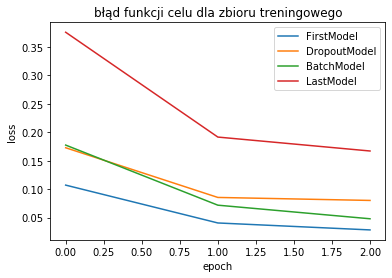

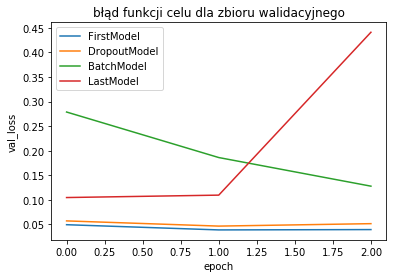

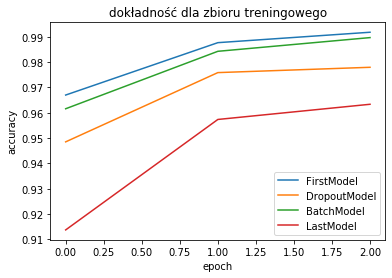

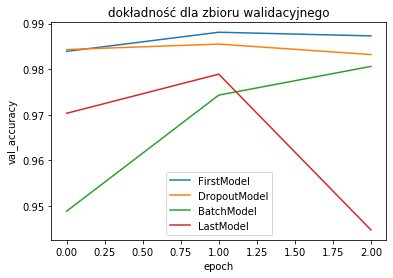

In [33]:
import matplotlib.pyplot as plt

def show_plot(title, key, model_1, model_2, model_3, model_4):
  plt.plot(model_1.history[key], label='FirstModel')
  plt.plot(model_2.history[key], label='DropoutModel')
  plt.plot(model_3.history[key], label='BatchModel')
  plt.plot(model_4.history[key], label='LastModel')

  plt.title(title)
  plt.xlabel('epoch')
  plt.ylabel(key)
  plt.legend()
  plt.show()

show_plot("błąd funkcji celu dla zbioru treningowego", 'loss', firstModel, dropoutModel, batchModel, lastModel)
show_plot("błąd funkcji celu dla zbioru walidacyjnego", 'val_loss', firstModel, dropoutModel, batchModel, lastModel)
show_plot("dokładność dla zbioru treningowego", 'accuracy', firstModel, dropoutModel, batchModel, lastModel)
show_plot("dokładność dla zbioru walidacyjnego", 'val_accuracy', firstModel, dropoutModel, batchModel, lastModel)